In [1]:
from __future__ import annotations
from IPython import get_ipython
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

from statsmodels.graphics.tsaplots import plot_acf


In [21]:
base_path = os.path.abspath('')

events_df = pd.read_csv(f"{base_path}/Data/events_complete.csv")
event_columns = [i for i in events_df.columns if "event_type" in i]
events_df["event_type"] = events_df.loc[:, event_columns].idxmax(axis=1)
events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view,event_type
0,2019-10-01 00:00:00 UTC,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0,event_type_cart
1,2019-10-01 00:00:03 UTC,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0,event_type_cart
2,2019-10-01 00:00:07 UTC,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0,event_type_cart
3,2019-10-01 00:00:07 UTC,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0,event_type_cart
4,2019-10-01 00:00:15 UTC,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0,event_type_cart


In [42]:
percent_missing = events_df.isnull().sum() * 100 / len(events_df)
product_columns_desc = pd.DataFrame({'columna': events_df.columns,
                                 'porcentaje_faltantes': percent_missing})
product_columns_desc["n_unicos"] = events_df.nunique()
product_columns_desc = product_columns_desc.drop(event_columns).drop(["date", "time", "sales"])
product_columns_desc["tipo"] = ['timestamp', 'categorica', 'categorica', 'categorica', 'categorica',
       'float64', 'id', 'id', 'categorica']
product_columns_desc = product_columns_desc.reset_index(drop=True)
product_columns_desc

,columna,porcentaje_faltantes,n_unicos,tipo
0,event_time,0.000000,8782890,timestamp
1,product_id,0.000000,54571,categorica
2,category_id,0.000000,525,categorica
3,category_code,98.291225,12,categorica
4,brand,42.319551,273,categorica
5,price,0.000000,2860,float64
6,user_id,0.000000,1639358,id
7,user_session,0.022220,4535941,id
8,event_type,0.000000,4,categorica


## Main variable: Sales

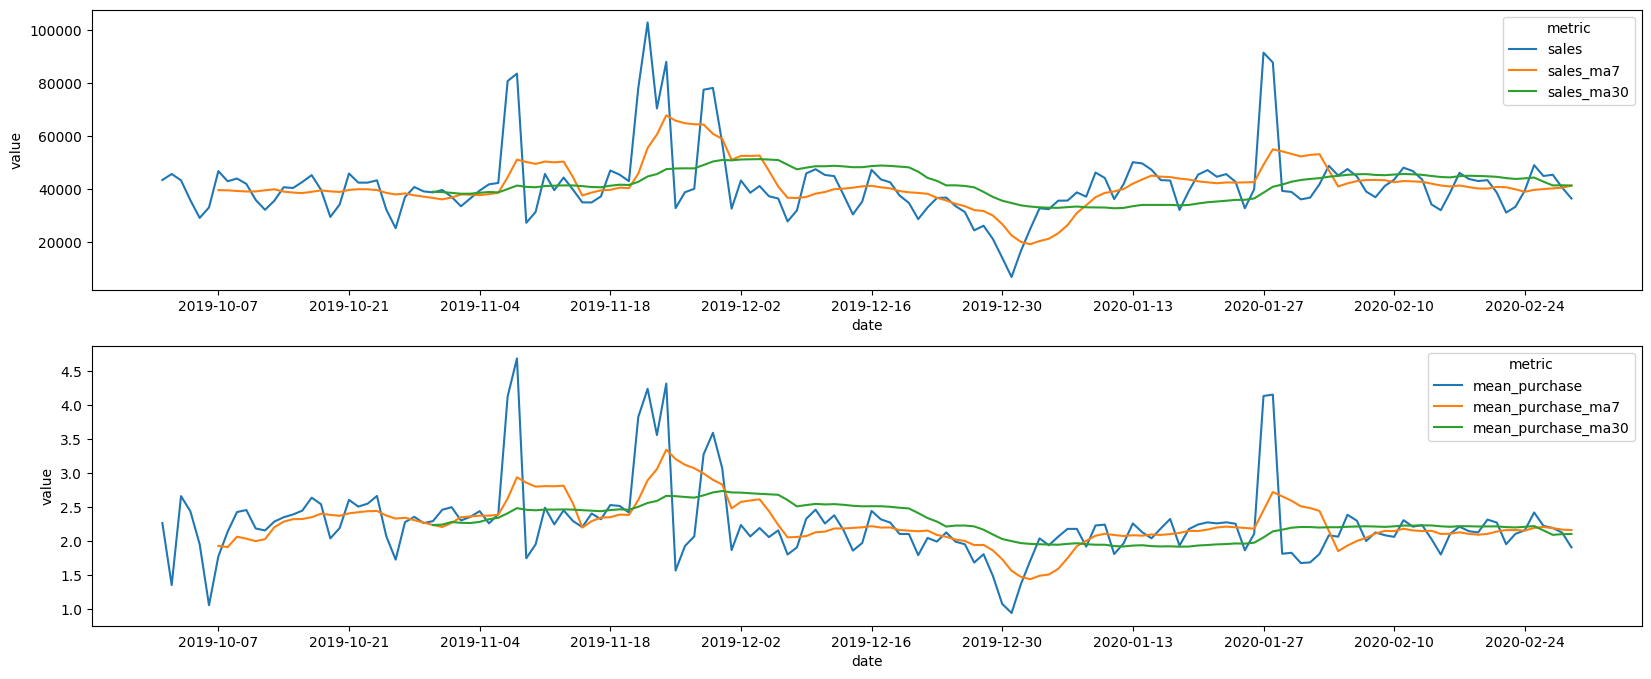

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
sales_by_user_day = events_df.groupby("date").agg({"sales":"sum", "user_id": "nunique"}).reset_index()

sales_by_user_day['sales_ma7'] = sales_by_user_day['sales'].rolling(7).mean()
sales_by_user_day['sales_ma30'] = sales_by_user_day['sales'].rolling(30).mean()

sales_by_user_day["mean_purchase"] = sales_by_user_day["sales"] / sales_by_user_day["user_id"]
sales_by_user_day['mean_purchase_ma7'] = sales_by_user_day['mean_purchase'].rolling(7).mean()
sales_by_user_day['mean_purchase_ma30'] = sales_by_user_day['mean_purchase'].rolling(30).mean()

sales_by_user_day_melted = sales_by_user_day.melt('date', var_name='metric', value_name='value')
chart_1 = sns.lineplot(sales_by_user_day_melted.loc[sales_by_user_day_melted["metric"].isin(["sales", "sales_ma7", "sales_ma30"])], x="date", y="value", hue="metric", ax=ax[0])
chart_2 = sns.lineplot(sales_by_user_day_melted.loc[sales_by_user_day_melted["metric"].isin(["mean_purchase", "mean_purchase_ma7", "mean_purchase_ma30"])], x="date", y="value", hue="metric", ax=ax[1])

locator = mdates.DayLocator(interval=14)
chart_1.xaxis.set_major_locator(locator)
chart_2.xaxis.set_major_locator(locator)

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_65989/2245864903.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


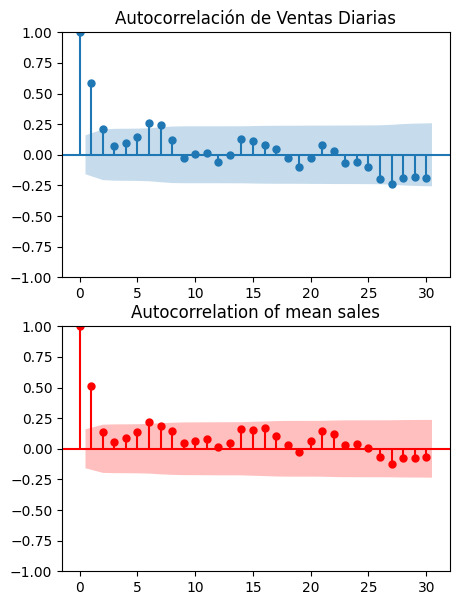

In [74]:
from matplotlib.collections import PolyCollection
my_color = "red"

fig, ax = plt.subplots(2, figsize=(5,7))
plot_acf(x=sales_by_user_day["sales"], lags=30, ax=ax[0], title="Autocorrelación de Ventas Diarias")
plot_acf(x=sales_by_user_day["mean_purchase"], lags=30, ax=ax[1], title="Autocorrelation of mean sales", color=my_color, vlines_kwargs={"colors": my_color})
for item in ax[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)
fig.show()

## Categorical variables

Análisis de las variables event_type, product_idcategory_id, brand

In [26]:
events_df.columns

Index(['event_time', 'product_id', 'category_id', 'category_code', 'brand',
       'price', 'user_id', 'user_session', 'time', 'date', 'sales',
       'event_type_cart', 'event_type_purchase', 'event_type_remove_from_cart',
       'event_type_view'],
      dtype='object')

#### event_type

In [97]:
# TODO: Reduce number of decimals shown
funnel_data = events_df.loc[:,["event_type_view", "event_type_cart", "event_type_remove_from_cart", "event_type_purchase"]].sum().reset_index()
funnel_data.columns = ["event_type", "n_events"]
funnel_data["event_type"] = funnel_data["event_type"].str.split("type_").str[1]

funnel_data["n_events"] = (funnel_data["n_events"] / 1_000_000).round(2)

fig = px.funnel(funnel_data, x='n_events', y='event_type')
fig.update_layout(title='Numero de Eventos (en millones) por Tipo de Evento', title_x=0.5, width=600, height=350)
fig.show()

#### product_id

In [125]:
product_columns = ["product_id", "category_id", "category_code", "brand"]

percent_missing = events_df.loc[:, product_columns].isnull().sum() * 100 / len(events_df)
product_columns_desc = pd.DataFrame({'column_name': product_columns,
                                 'percent_missing': percent_missing})
product_columns_desc["nunique"] = events_df.loc[:, product_columns].nunique()
product_columns_desc

,column_name,percent_missing,nunique
product_id,product_id,0.000000,54571
category_id,category_id,0.000000,525
category_code,category_code,98.291225,12
brand,brand,42.319551,273


category_code is practically null, not useful

In [152]:
counts = events_df.loc[:,['product_id','category_id']].dropna().groupby('product_id')['category_id'].nunique()

# Check if every product_id belongs to only one category_id
is_unique_category = (counts == 1).all()

len(counts[counts!=1])

1619

In [156]:
counts = events_df.loc[:,['product_id','brand']].dropna().groupby('product_id')['brand'].nunique()

# Check if every product_id belongs to only one category_id
is_unique_category = (counts == 1).all()

len(counts[counts!=1])

24

There are product_ids with more than one category or brand, although there are many less product_ids with many brands

Text(0, 0.5, 'Frecuencia')

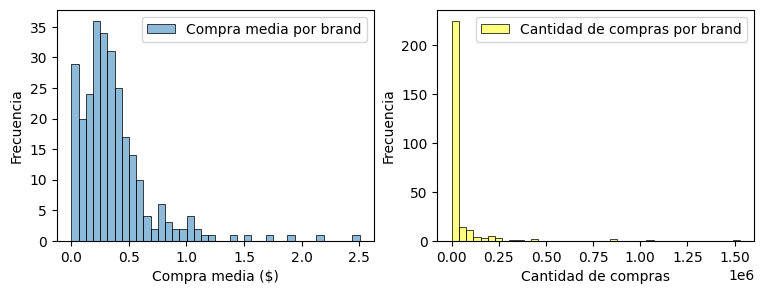

In [97]:
fig, ax = plt.subplots(1,2, figsize=(9, 3))
sns.histplot(events_df.groupby("brand")["sales"].mean(), bins=40, label=f"Compra media por brand", ax=ax[0], alpha=0.5)
sns.histplot(events_df.groupby("brand")["sales"].count(), bins=40, label=f"Cantidad de compras por brand", ax=ax[1], alpha=0.5, color="yellow")

ax[0].legend()
ax[0].set_xlabel('Compra media ($)')
ax[0].set_ylabel('Frecuencia')
ax[1].legend()
ax[1].set_xlabel('Cantidad de compras')
ax[1].set_ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

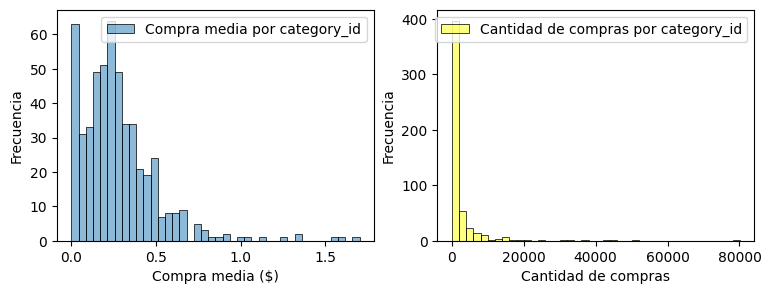

In [96]:
fig, ax = plt.subplots(1,2, figsize=(9, 3))
sns.histplot(events_df[events_df["sales"]>=0].groupby("category_id")["sales"].mean(), bins=40, label=f"Compra media por category_id", ax=ax[0], alpha=0.5)
sns.histplot(events_df[events_df["sales"]>=0].groupby("category_id")["event_type_purchase"].sum(), bins=40, label=f"Cantidad de compras por category_id", ax=ax[1], alpha=0.5, color="yellow")

ax[0].legend()
ax[0].set_xlabel('Compra media ($)')
ax[0].set_ylabel('Frecuencia')
ax[1].legend()
ax[1].set_xlabel('Cantidad de compras')
ax[1].set_ylabel('Frecuencia')

Very skewed, could be used for cuped. catogory_id might be better since it has way less nulls

WARNING: We don't have user based categorical features, we could invent them using something like "main brand/category" or simulate them. This is if we use user as RU

#### Purchase quantity

Are every purchase event for just one product? We can check by grouping by session and product_id and see if there are many cases with more than just one line

In [56]:
counts = events_df.loc[events_df["event_type"]=="event_type_purchase"].groupby(["user_session", "product_id"]).agg({"sales":["count", "sum"]}).reset_index()
counts.loc[counts[("sales", "count")]>7]

user_session product_id sales        
                                                         count     sum
368414   49bc852c-cbc7-4d84-9a2c-8144205b571a       5304     9    2.88
368420   49bc852c-cbc7-4d84-9a2c-8144205b571a    5751422    10  109.50
368421   49bc852c-cbc7-4d84-9a2c-8144205b571a    5809910    10   52.40
368422   49bc852c-cbc7-4d84-9a2c-8144205b571a    5809912     9   47.16
505280   64e9a45a-db0e-4a68-8d64-ada1a26a5b6f    5802432     8    2.56
1252940  fb5a2f8f-837c-4e50-9b3d-bdcbdc75315e    5778113     9   47.88

In [67]:
events_df.loc[(events_df["user_session"]=="49bc852c-cbc7-4d84-9a2c-8144205b571a") & (events_df["event_type"]=="event_type_purchase") & (events_df["product_id"]==5304)]

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view,event_type
14940543,2020-01-21 09:13:06 UTC,5304,1487580009471148064,NaN,runail,0.32,230818889,49bc852c-cbc7-4d84-9a2c-8144205b571a,2020-01-21 09:13:06+00:00,2020-01-21,0.32,0.0,1.0,0.0,0.0,event_type_purchase
14941196,2020-01-21 09:17:19 UTC,5304,1487580009471148064,NaN,runail,0.32,230818889,49bc852c-cbc7-4d84-9a2c-8144205b571a,2020-01-21 09:17:19+00:00,2020-01-21,0.32,0.0,1.0,0.0,0.0,event_type_purchase
14941644,2020-01-21 09:19:54 UTC,5304,1487580009471148064,NaN,runail,0.32,230818889,49bc852c-cbc7-4d84-9a2c-8144205b571a,2020-01-21 09:19:54+00:00,2020-01-21,0.32,0.0,1.0,0.0,0.0,event_type_purchase
15815861,2020-01-27 12:59:34 UTC,5304,1487580009471148064,NaN,runail,0.32,230818889,49bc852c-cbc7-4d84-9a2c-8144205b571a,2020-01-27 12:59:34+00:00,2020-01-27,0.32,0.0,1.0,0.0,0.0,event_type_purchase
15816286,2020-01-27 13:01:28 UTC,5304,1487580009471148064,NaN,runail,0.32,230818889,49bc852c-cbc7-4d84-9a2c-8144205b571a,2020-01-27 13:01:28+00:00,2020-01-27,0.32,0.0,1.0,0.0,0.0,event_type_purchase
15816521,2020-01-27 13:02:31 UTC,5304,1487580009471148064,NaN,runail,0.32,230818889,49bc852c-cbc7-4d84-9a2c-8144205b571a,2020-01-27 13:02:31+00:00,2020-01-27,0.32,0.0,1.0,0.0,0.0,event_type_purchase
16858292,2020-02-03 06:49:34 UTC,5304,1487580009471148064,NaN,runail,0.32,230818889,49bc852c-cbc7-4d84-9a2c-8144205b571a,2020-02-03 06:49:34+00:00,2020-02-03,0.32,0.0,1.0,0.0,0.0,event_type_purchase
16858606,2020-02-03 06:51:39 UTC,5304,1487580009471148064,NaN,runail,0.32,230818889,49bc852c-cbc7-4d84-9a2c-8144205b571a,2020-02-03 06:51:39+00:00,2020-02-03,0.32,0.0,1.0,0.0,0.0,event_type_purchase
16858723,2020-02-03 06:52:36 UTC,5304,1487580009471148064,NaN,runail,0.32,230818889,49bc852c-cbc7-4d84-9a2c-8144205b571a,2020-02-03 06:52:36+00:00,2020-02-03,0.32,0.0,1.0,0.0,0.0,event_type_purchase
